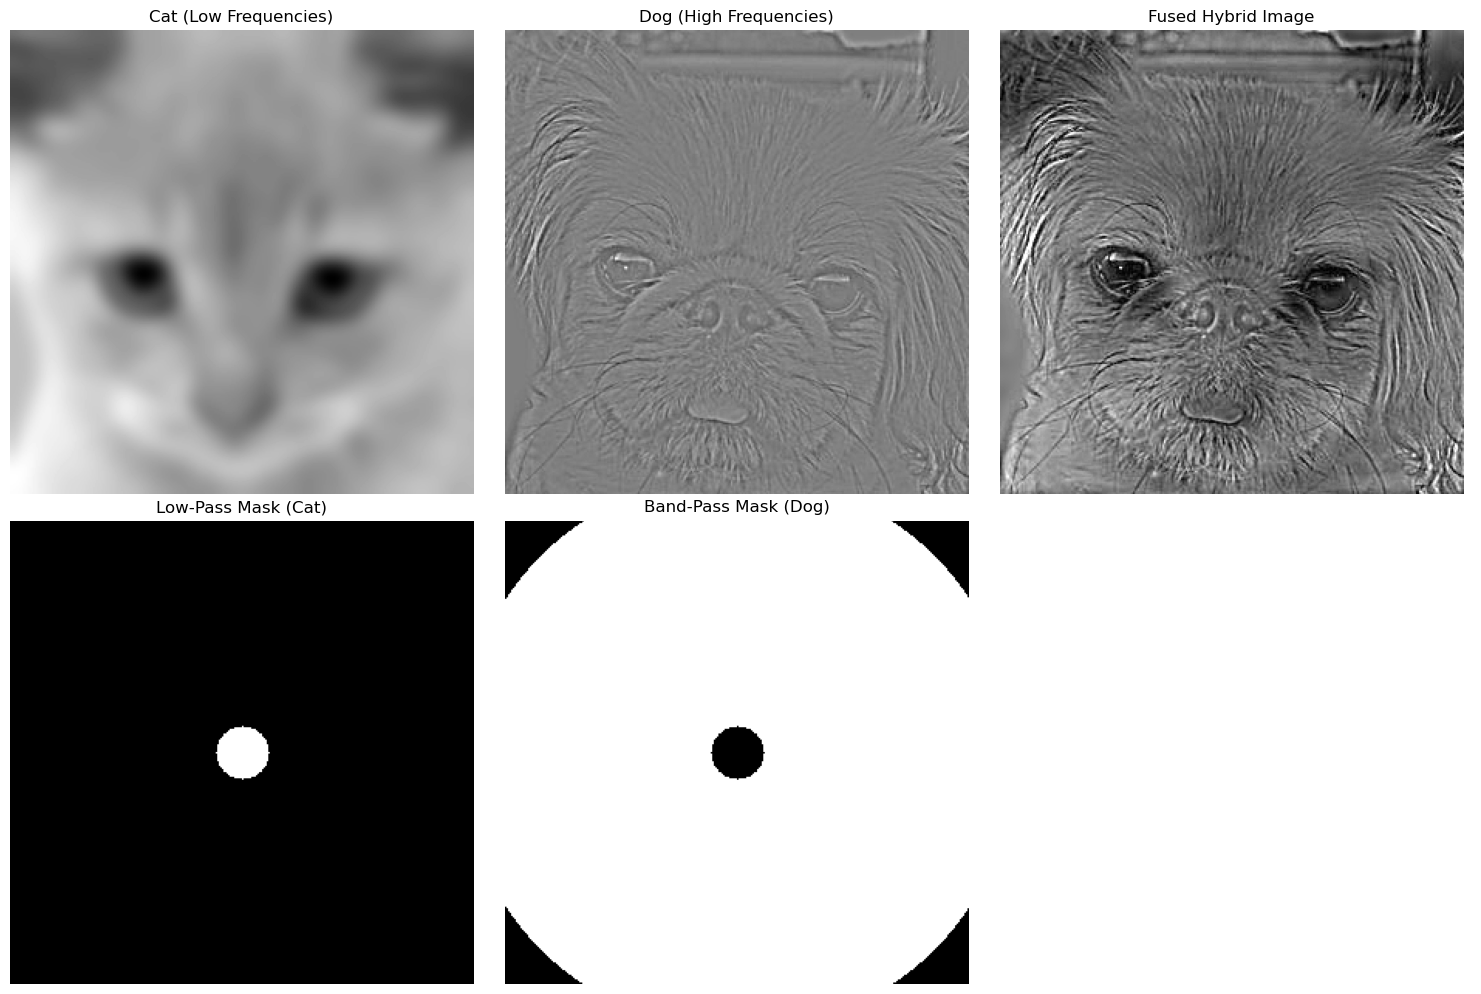

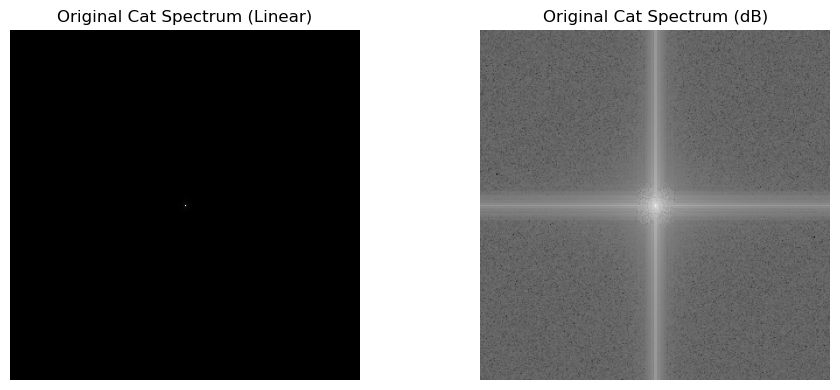

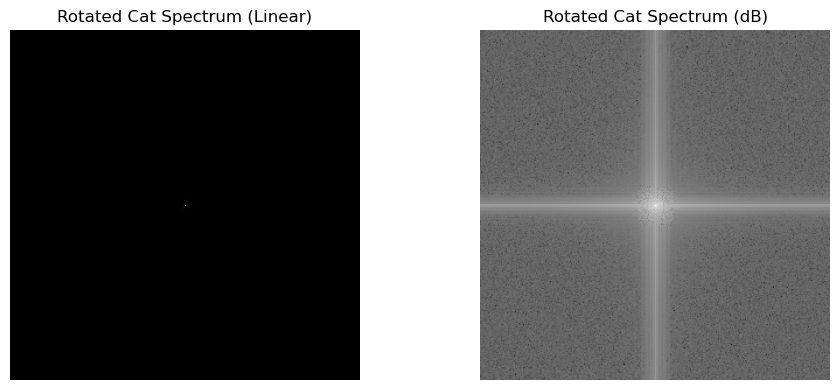

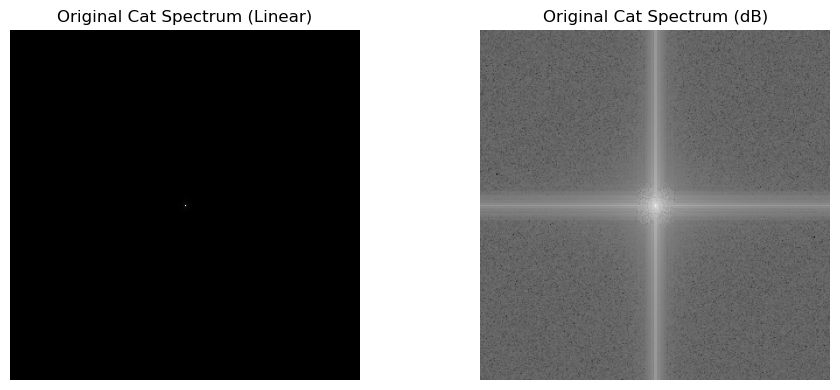

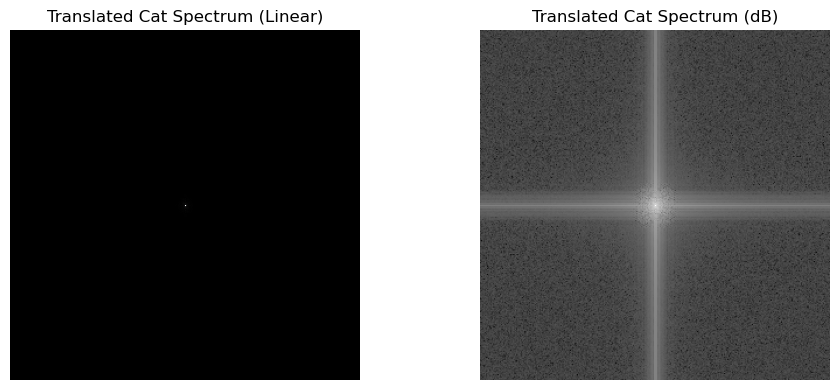

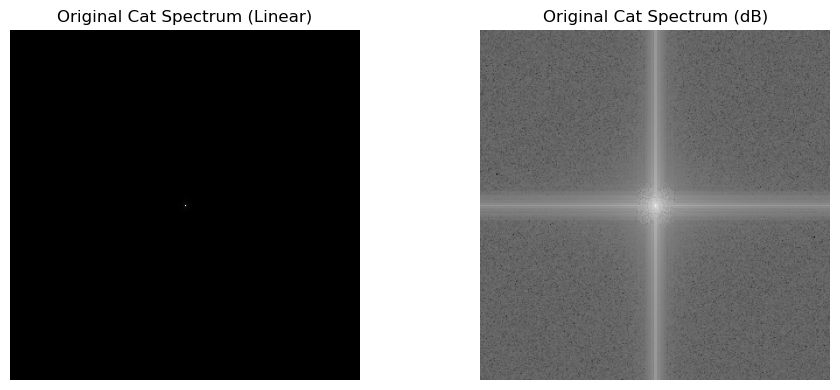

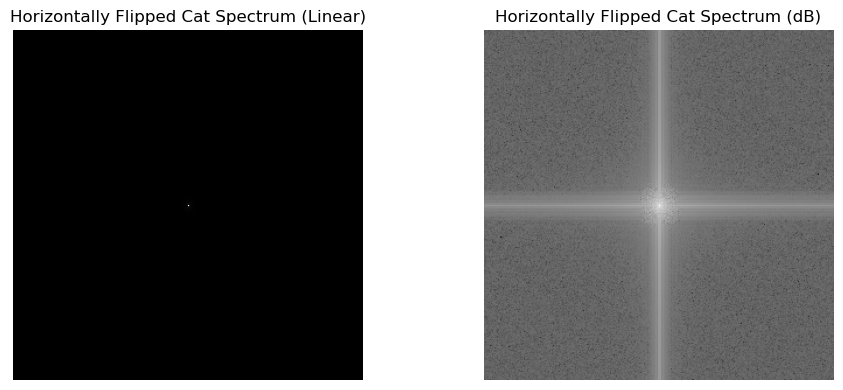

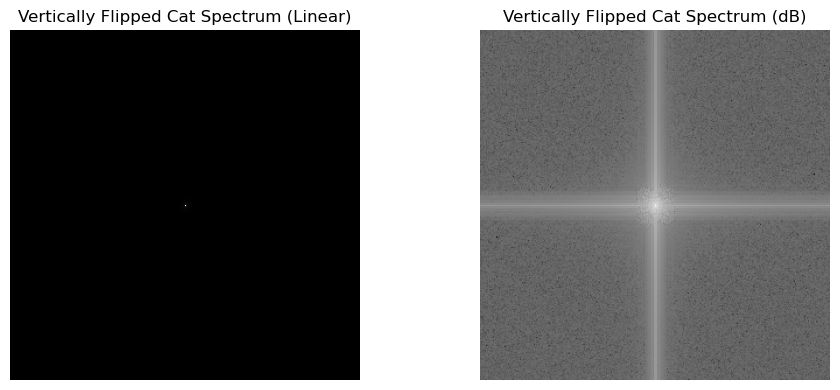

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from scipy.ndimage import gaussian_filter, laplace
from scipy.ndimage import shift


def prepare_images(cat_path, dog_path):
    cat = Image.open(cat_path).convert("L")
    dog = Image.open(dog_path).convert("L")

    size = (300, 300)
    cat = ImageOps.fit(cat, size, centering=(0.5, 0.5))
    dog = ImageOps.fit(dog, size, centering=(0.5, 0.5))

    cat_np = np.array(cat).astype(np.float32)
    dog_np = np.array(dog).astype(np.float32)

    # CAT: Smooth with larger sigma → keeps only low frequencies
    cat_blur = gaussian_filter(cat_np, sigma=6)

    # DOG: High-pass by subtracting blurred version
    dog_blur = gaussian_filter(dog_np, sigma=2)
    dog_high = dog_np - dog_blur
    dog_high = (dog_high - dog_high.min()) / dog_high.ptp() * 255

    # Normalize dog_high to 0–255 with contrast
    dog_high = (dog_high - dog_high.min()) / (dog_high.ptp()) * 255

    return cat_blur.astype(np.uint8), dog_high.astype(np.uint8)


def hybrid_fusion(low_img, high_img, radius_low, radius_high, illumination_boost):
    # Compute FFTs
    fft_low = np.fft.fftshift(np.fft.fft2(low_img))
    fft_high = np.fft.fftshift(np.fft.fft2(high_img))

    rows, cols = low_img.shape
    crow, ccol = rows // 2, cols // 2
    Y, X = np.ogrid[:rows, :cols]
    dist = np.sqrt((X - ccol)**2 + (Y - crow)**2)

    # Define frequency masks
    low_pass_mask = dist <= radius_low
    band_pass_mask = (dist > radius_low) & (dist < radius_high)

    # Apply masks to FFTs
    low_component = fft_low * low_pass_mask
    high_component = fft_high * band_pass_mask * 3

    # Combine components in frequency domain
    fused_fft = low_component + high_component
    fused = np.abs(np.fft.ifft2(np.fft.ifftshift(fused_fft)))

    # Normalize to 0–255 and boost illumination
    fused = 255 * (fused - fused.min()) / fused.ptp()
    fused *= illumination_boost

    # Clip to valid range and convert to uint8
    fused = np.clip(fused, 0, 255).astype(np.uint8)

    return fused, low_pass_mask, band_pass_mask


# Utility to plot FFT spectrum in linear and dB scale
def plot_fft_magnitude(img, title_prefix="Image"):
    fft = np.fft.fft2(img)
    fft_shifted = np.fft.fftshift(fft)
    magnitude = np.abs(fft_shifted)
    magnitude_db = 20 * np.log10(magnitude + 1e-8)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(magnitude, cmap='gray')
    axs[0].set_title(f"{title_prefix} Spectrum (Linear)")

    axs[1].imshow(magnitude_db, cmap='gray')
    axs[1].set_title(f"{title_prefix} Spectrum (dB)")

    for ax in axs:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


# Load, align and prepare images
cat_path = "C:/Users/sujit/Downloads/EE200_practical_programming (1)/EE200_practical_programming/cat_gray.jpg"
dog_path = "C:/Users/sujit/Downloads/EE200_practical_programming (1)/EE200_practical_programming/dog_gray.jpg"

cat_struct, dog_detail = prepare_images(cat_path, dog_path)

# Fuse in frequency domain
fused, low_mask, band_mask = hybrid_fusion(cat_struct, dog_detail, radius_low=17, radius_high=180, illumination_boost=1.5)

# Plot results
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].imshow(cat_struct, cmap='gray')
axs[0, 0].set_title("Cat (Low Frequencies)")
axs[0, 1].imshow(dog_detail, cmap='gray')
axs[0, 1].set_title("Dog (High Frequencies)")
axs[0, 2].imshow(fused, cmap='gray')
axs[0, 2].set_title("Fused Hybrid Image")

axs[1, 0].imshow(low_mask, cmap='gray')
axs[1, 0].set_title("Low-Pass Mask (Cat)")

axs[1, 1].imshow(band_mask, cmap='gray')
axs[1, 1].set_title("Band-Pass Mask (Dog)")

axs[1, 2].axis("off")

for ax in axs.flatten():
    ax.axis("off")
plt.tight_layout()
plt.show()


# Plot 2D FFT Magnitude Spectra for Cat (original and rotated)
plot_fft_magnitude(cat_struct, "Original Cat")

rotated_cat = np.rot90(cat_struct)
plot_fft_magnitude(rotated_cat, "Rotated Cat")



# Translate cat image: 50 pixels right, 30 pixels down
translated_cat = shift(cat_struct, shift=(30, 50), mode='wrap')

# Plot FFT magnitude of original and translated image
plot_fft_magnitude(cat_struct, "Original Cat")
plot_fft_magnitude(translated_cat, "Translated Cat")

# Flip cat image horizontally and vertically
cat_flip_h = np.fliplr(cat_struct)  # Left–Right flip
cat_flip_v = np.flipud(cat_struct)  # Up–Down flip

# Plot FFT magnitude for original, horizontal flip, and vertical flip
plot_fft_magnitude(cat_struct, "Original Cat")
plot_fft_magnitude(cat_flip_h, "Horizontally Flipped Cat")
plot_fft_magnitude(cat_flip_v, "Vertically Flipped Cat")
